# Introduzione 

In questo esercizio implementiamo l'algoritmo di Metropolis per studiare le proprietà termodinamiche dell'Argon nell'ensemble canonico. Abbiamo visto nella lezione precedente l'utilizzo dell'algoritmo di metropolis per lo studio delle proprietà medie del modello di Ising. In questo caso eseguiamo lo stesso tipo di istruzioni però al posto di avere un reticolo di valori di spin abbiamo 108 particelle caratterizzata dalla loro posizione. La scelta che facciamo per la probabilità condizionata $T(x|y)$ è una distribuzione uniforme centrata nell'intorno del punto attuale $\vec x_{i+1}=[ \vec x_i-\vec \delta, \vec x_i+\vec \delta].$ Invece la distribuzione di accettazione $A(x|y)$ è data dal rapporto fra i pesi di Boltzmann delle due configurazioni: 
$$A(x|y)=\min \left[ 1, e^{-\beta(E_{\vec x} -E_{\vec y})}\right]$$




Avendo già simulato il sistema nell'esamble microcanonico attraverso l'algoritmo di Verlet, ci cureremo poi di confrontare i risultati. 


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import string
from scipy.optimize import curve_fit
import scipy
from scipy.special import erf
from scipy import log, exp, sqrt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stat
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import subprocess as sb
from os import system
import os
import shutil

sns.set_theme(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True, rc=None)

# Preparazione del sistema

Cominciamo analizzando le proprietà dei nostri algoritmi di simulazione. In particolare osserviamo prima quale sia il tempo di equilibrazione, ossia il tempo richiesto all'algoritmo per giungere ad una condizione di equilibrio. Studiamo poi la funzione di correlazione per determinare quale sia la migliore dimensione dei blocchi. Infine confermiamo i risultati ottenuti attraverso un'analisi dell'incertezza ottenuta attraverso la blocking average.

In [2]:
phases = ['solid', 'liquid', 'gas','dat']
out = ['epot','pres','gave','gofr']
path1 = os.path.abspath(os.getcwd())
path = os.path.abspath(os.getcwd())+'/MonteCarlo_NVT/'

os.chdir(path)

In [3]:
# Physical constants in SI units (arbitrarily approximated...)
boltzmann_constant = 1.381e-23
atomic_mass_unit = 1.661e-27

# Utilities
L_block = 20
integration_step = 0.0005

# Unit scales
length = 0.34e-9                 
energy = 120 * boltzmann_constant
mass = 39.948 * atomic_mass_unit

time = np.sqrt(mass * length**2 / energy)
temp = energy/boltzmann_constant
pres = energy * length**(-3)

## Tempo di equilibrazione

In [4]:
# 0. temp; 1. npart; 2. rho; 3. rcut; 4. delta; 5. nblk; 6. nstep; 7. equilibration_time 

epot_ist = np.zeros((3,10000))
pres_ist = np.zeros((3,10000))

for i in range(3):
    
    # Copio il file input."stato" in input.dat
    shutil.copyfile(path+'input.'+phases[i], path+'input.'+phases[3])
    
    # Cambio il numero di step
    a_file = open(path+'input.'+phases[3], "r")
    list_of_lines = a_file.readlines()
    list_of_lines[5] = "10000\n"
    list_of_lines[6] = "1\n"
    list_of_lines[7] = "0\n"
    a_file = open(path+'input.'+phases[3], "w")
    a_file.writelines(list_of_lines)
    a_file.close()
    
    # Compilo il programma con il nuovo file di input
    sb.call('./clean.sh', shell=True)
    os.system('./Monte_Carlo_NVT.exe %f %f')
    
     # Salvo le informazioni che mi interessano
    appo = np.loadtxt(path+'output.epot.0', unpack = True)
    epot_ist[i] = appo[1,:]
    appo = np.loadtxt(path+"output.pres.0", unpack = True)
    pres_ist[i] = appo[1,:]

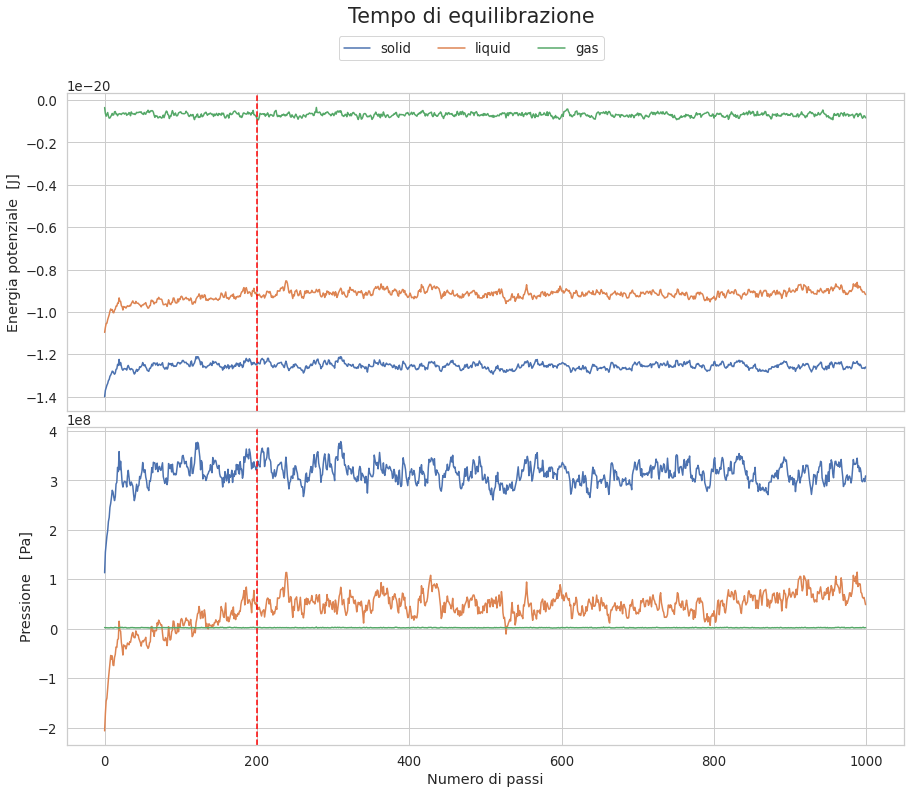

In [5]:
fig = plt.figure(figsize=(15,12))
fig.suptitle(r'Tempo di equilibrazione', fontsize='x-large')

gs = fig.add_gridspec(2, 1, hspace=0.05, wspace=0)

ax = gs.subplots(sharex='col');

ax = ax.ravel()


for i in range(3):
    # Ne faccio un grafico
    ax[0].plot(epot_ist[i,:1000]*energy,label=phases[i])
    ax[1].plot(pres_ist[i,:1000]*pres,label=phases[i])
    

ax[0].axvline(200, linestyle='--', color='red')
ax[1].axvline(200, linestyle='--', color='red')
ax[0].set_ylabel('Energia potenziale  [J]')
ax[1].set_ylabel('Pressione   [Pa]')
ax[1].set_xlabel('Numero di passi')
ax[0].legend(bbox_to_anchor=(0.65,1.2), ncol=3);

> Osserviamo che dopo circa 200 passi il sistema si stabilizza e questo vuol dire che è stato raggiunto l'equilibrio.

## Funzione di autocorrelazione

Calcolo ora la funzione di autocorrelazione per identificare la corretta lunghezza dei blocchi. Chiaramente per farlo considero il sistema una volta che ha già raggiunto l'equilibrio, ossia dopo 200 passi. Dopodichè fittiamo la curva con un modello esponenziale e valutiamo la bondà dei fit attraverso un test di Kolmogorov-Smirnov dal momento che non possiamo avanzare lcuna ipotesi sulla natura delle fluttuazioni della funzione di autocorrelazione. 

In [6]:
def autocovariance(series, lag):
    n = len(series)
    mean = 0
    for x in series:
        mean += x
    mean /= n
    c = 0
    for i in range(n - lag):
        c += (series[i] - mean)*(series[i + lag] - mean)
    return c / n

def autocorrelation(series, lag):
    return autocovariance(series, lag) / autocovariance(series, 0)

def exp_fit(t, t0):
    return [np.exp(-x / t0) for x in t]

1.  solid
[Energia potenziale]
Lunghezza di correlazione: 6.902587244043248 +- 0.3799971405498993
Risultati dei goodness-of-fit test: KstestResult(statistic=0.568, pvalue=9.327109742594374e-75)


[Pressione]
Lunghezza di correlazione: 6.850227140207147 +- 0.3725496575366205
Risultati dei goodness-of-fit test: KstestResult(statistic=0.57, pvalue=2.5664403877711904e-75)
-----------------------------------------------------------------------


2.  liquid
[Energia potenziale]
Lunghezza di correlazione: 4.759765267742095 +- 0.2371282791588075
Risultati dei goodness-of-fit test: KstestResult(statistic=0.518, pvalue=1.4764089619263375e-61)


[Pressione]
Lunghezza di correlazione: 4.494554810124414 +- 0.2526921295361729
Risultati dei goodness-of-fit test: KstestResult(statistic=0.52, pvalue=4.681770524003254e-62)
-----------------------------------------------------------------------


3.  gas
[Energia potenziale]
Lunghezza di correlazione: 2.2338512159323156 +- 0.1282740578193542
Risultati de

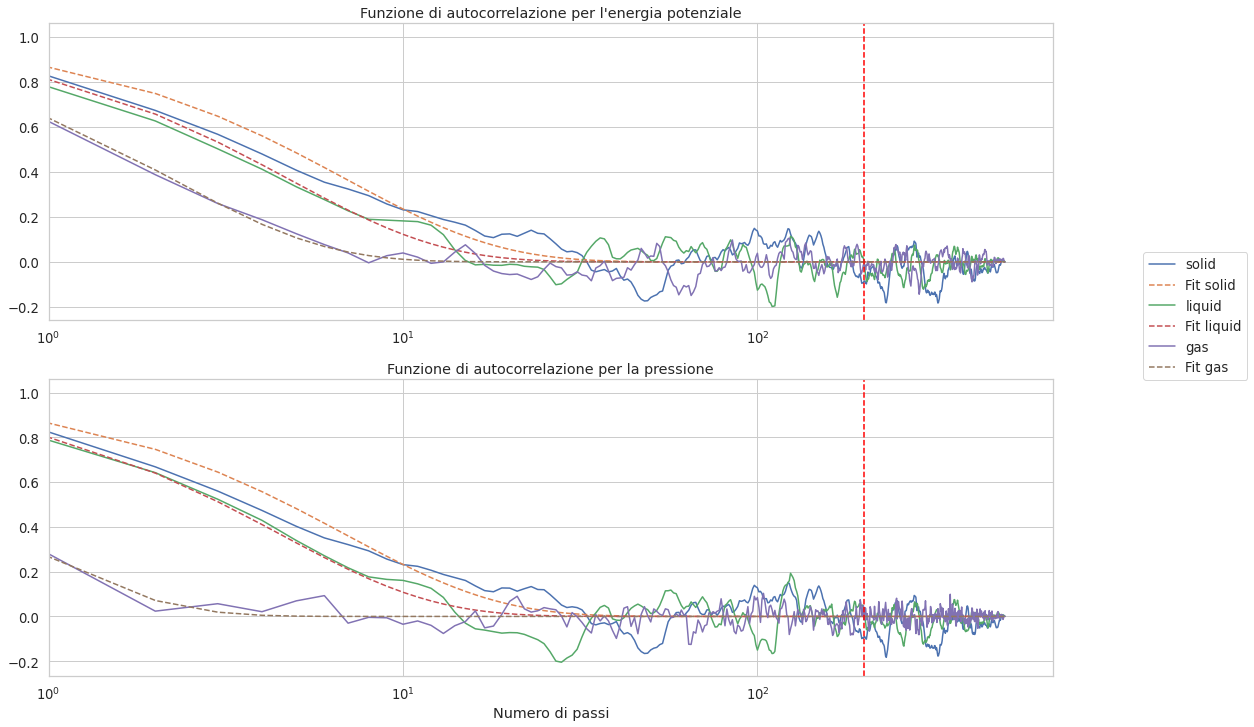

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(18,12)); 
ax = ax.ravel()
max_lag=500

for i in range(3):
    
    epot_fit = [autocorrelation(epot_ist[i,200:700],j) for j in range(max_lag)]
    pres_fit = [autocorrelation(pres_ist[i,200:700],j) for j in range(max_lag)]
    
    n_step = np.size(epot_fit) 
    x= np.linspace(0,n_step,n_step)
    
    popt, pcov = curve_fit(exp_fit, x,epot_fit)
    popt2, pcov2 = curve_fit(exp_fit, x, pres_fit)
    ax[0].plot(epot_fit,label=phases[i])
    ax[1].plot(pres_fit, label=phases[i])
    ax[0].plot(x, exp_fit(x, *popt),linestyle = '--', label='Fit '+phases[i])
    ax[1].plot(x, exp_fit(x, *popt2), linestyle = '--', label='Fit '+phases[i])
    
    
    print(str(i+1)+'.  '+phases[i])
    print("[Energia potenziale]")
    print("Lunghezza di correlazione: "+ str(popt[0]) + " +- " + str(np.sqrt(np.diag(pcov))[0]))
    print("Risultati dei goodness-of-fit test:", stat.kstest(epot_fit, exp_fit(x, *popt)))
    print("\n")
    print("[Pressione]")
    print("Lunghezza di correlazione: "+ str(popt2[0]) + " +- " + str(np.sqrt(np.diag(pcov2))[0]))
    print("Risultati dei goodness-of-fit test:", stat.kstest(pres_fit, exp_fit(x, *popt2)))
    print("-----------------------------------------------------------------------")
    print("\n")
    

ax[0].axvline(200, linestyle='--', color='red')
ax[1].axvline(200, linestyle='--', color='red')    
ax[0].set_title("Funzione di autocorrelazione per l'energia potenziale");
ax[1].set_title("Funzione di autocorrelazione per la pressione");
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xlim(1);
ax[1].set_xlim(1);
ax[1].set_xlabel('Numero di passi')
ax[0].legend(bbox_to_anchor=(1.2,0.25), ncol=1);

> Come ci testimoniamo i k-test, i nostri fit non descrivono in modo abbastanza preciso le curve per consentirci di stimare da qui la lunghezza di correlazione. Per questo motivo, stiamamo la lunghezza di correlazione uguale a 200 step attraverso un'analisi visiva delle diverse curve. 

## Analisi dell'incertezza sui blocchi

Quello che ora vogliamo fare è valutare la consistenza della scelta della dimensione dei blocchi. Per farlo variamo la dimensione dei blocchi in un range da 10 a 5000 passi.

In [8]:
def error(AV,AV2,n):  # Function for statistical uncertainty estimation
    if n==0:
        return 0
    else:
        return math.sqrt((AV2 - AV**2)/n)


def Block_error(r,L):
    N = int(np.size(r)/L)
    ave = np.zeros(N)
    av2 = np.zeros(N)
    sum_prog = 0
    su2_prog = 0

    for i in range(N):
        sum = 0
        for j in range(L):
            k = j+i*L
            sum += r[k]
        ave[i] = sum/L       # r_i 
        av2[i] = (ave[i])**2 # (r_i)^2 

    for j in range(N):
        sum_prog += ave[j] # SUM_{j=0,i} r_j
        su2_prog += av2[j] # SUM_{j=0,i} (r_j)^2
        
    sum_prog/=(N) # Cumulative average
    su2_prog/=(N) # Cumulative square average
    err_prog = error(sum_prog,su2_prog,N-1) # Statistical uncertainty
    
    return err_prog

In [9]:
block_size = np.arange(10,2500,10, dtype=int)

epot_std = np.zeros((3,np.size(block_size)))
pres_std = np.zeros((3,np.size(block_size)))

for j in range(np.size(block_size)):
    for i in range(3):
        epot_std[i][j] = Block_error(epot_ist[i,:],block_size[j])
        pres_std[i][j] = Block_error(pres_ist[i,:],block_size[j])

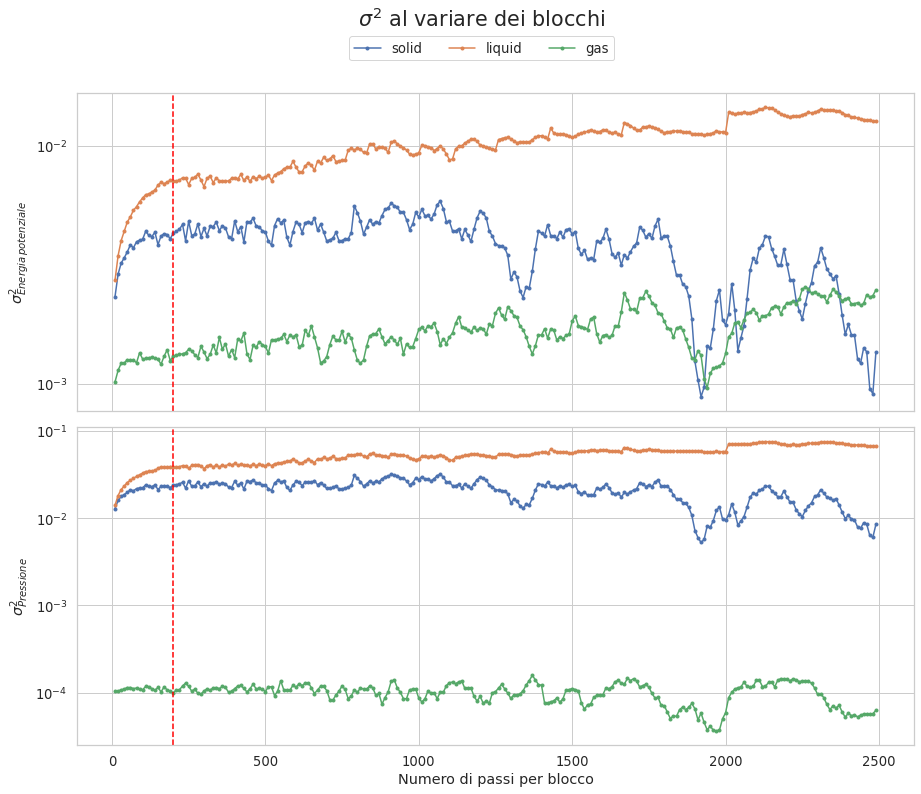

In [10]:
fig = plt.figure(figsize=(15,12))
fig.suptitle(r'$\sigma^2$ al variare dei blocchi', fontsize='x-large')

gs = fig.add_gridspec(2, 1, hspace=0.05, wspace=0)

ax = gs.subplots(sharex='col');

ax = ax.ravel()


for i in range(3):
    # Ne faccio un grafico
    ax[0].plot(block_size,epot_std[i,:],label=phases[i],marker='.')
    ax[1].plot(block_size,pres_std[i,:],label=phases[i],marker='.')

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].axvline(200, linestyle='--', color='red')
ax[1].axvline(200, linestyle='--', color='red')
ax[0].set_ylabel(r'$\sigma_{Energia\, potenziale}^2$')
ax[1].set_ylabel(r'$\sigma^2_{Pressione}$')
ax[1].set_xlabel('Numero di passi per blocco')
ax[0].legend(bbox_to_anchor=(0.65,1.2), ncol=3);

In questo grafico sono osservabili tre diversi comportamenti. In una fase iniziale in cui $10\lesssim n_{\text{step}}\lesssim 200$, osserviamo che l'incertezza cresce notevolemente aumentando la taglia dei blocchi. Questo è dovuto al fatto che i passi sono fortemente correlate e questo conferma la nostra precedente indagine. E' poi presente un platau per dimensione dei blocchi $200\lesssim n_{\text{step}}\lesssim 1000$ in cui la $\sigma^2$ si stabilizza. In questo intervallo abbiamo la dimensione ottimale dei blocchi. Infatti aumentando ancora la taglia, riduciamo il numero di blocchi totali così da incrementare notevolemente la volatilità. Questo succede per blocchi con dimensione $1000\lesssim n_{\text{step}}\lesssim 5000$.

> Concludiamo quindi questa indagine preliminare avendo appreso che:

| ||
|-----------------------------|--------|
|Tempo di equilibrazione      |$n_{\text{step}}=200$|
|Lunghezza di correlazione    |$n_{\text{step}}=200$      |
|Dimensione ottimale blocchi  | $200\lesssim n_{\text{step}}\lesssim 1000$ |


# Misure

Ora simuliamo il sistema attraverso l'algoritmo di Metropolis e confrontiamo i risultati per la distribuzione radiale con quelli simulati attraverso l'algoritmo di Verlet. In particolare per entrambi gli algoritmi consideriamo i seguenti parametri:

| ||
|-----------------------------|--------|
|Dimensione blocchi  | 200 |
|Numero di blocchi | 100 |



In [11]:
# 0. temp; 1. npart; 2. rho; 3. rcut; 4. delta; 5. nblk; 6. nstep; 7. equilibration_time
#path = r'/home/elia/Scrivania/SimulazioneNumerica/Exercises_07/MonteCarlo_NVT/'

os.chdir(path)
n_block = 100
n_bin = 100

epot_NVT = np.zeros((3,n_block))
gave_NVT =  np.zeros((3,n_bin))
pres_NVT = np.zeros((3,n_block))
epot_std_NVT = np.zeros((3,n_block))
pres_std_NVT = np.zeros((3,n_block))
gave_std_NVT = np.zeros((3,n_bin))
r_NVT  = np.zeros((3,n_bin))

for i in range(3):
    
    print(i)
    
    # Copio il file input."stato" in input.dat
    shutil.copyfile(path+'input.'+phases[i], path+'input.'+phases[3])
    
    # Cambio il numero di step
    a_file = open(path+"input.dat", "r")
    list_of_lines = a_file.readlines()
    list_of_lines[5] = str(n_block)+"\n"
    list_of_lines[6] = "200\n"
    list_of_lines[7] = "200\n"
    a_file = open(path+"input.dat", "w")
    a_file.writelines(list_of_lines)
    a_file.close()
    
     # Compilo il programma con il nuovo file di input
    sb.call('./clean.sh', shell=True)
    os.system('./Monte_Carlo_NVT.exe %f %f')
    
     # Salvo le informazioni che mi interessano
    appo = np.loadtxt(path+'output.epot.0', unpack = True)
    epot_NVT[i] = appo[2,:]
    epot_std_NVT[i] = appo[3,:]
    appo = np.loadtxt(path+'output.pres.0', unpack = True)
    pres_NVT[i] = appo[2,:]
    pres_std_NVT[i] = appo[3,:]
    appo = np.loadtxt(path+"output.gave.0", unpack = True)
    r_NVT[i] = appo[0,:] 
    gave_NVT[i] = appo[1,:]
    gave_std_NVT[i] = appo[2,:]
    

0
1
2


In [12]:
# 0. temp; 1. npart; 2. rho; 3. rcut; 4. delta; 5. nstep; 6. nblk; 7. iprint;8. start_old; 9. rescale_velocity; 10. equilibration_ime

path = path1+'/MolDyn_NVE/'
os.chdir(path)
n_block = 100
n_bin = 100
equilibration =[15,60,250]

epot = np.zeros((3,n_block))
gave =  np.zeros((3,n_bin))
epot_std = np.zeros((3,n_block))
gave_std = np.zeros((3,n_bin))
pres = np.zeros((3,n_block))
pres_std = np.zeros((3,n_block))
r = np.zeros((3,n_bin))

for i in range(3):
    
    print(i)
    
    # Cambio il numero di step
    a_file = open(path+'input.'+phases[i], "r")
    list_of_lines = a_file.readlines()
    list_of_lines[6] = str(n_block)+"\n"
    list_of_lines[5] = "200\n"
    list_of_lines[8] = "1\n"
    list_of_lines[9] = "1\n"
    list_of_lines[10] = str(equilibration[i])+"\n"
    a_file = open(path+'input.'+phases[i], "w")
    a_file.writelines(list_of_lines)
    a_file.close()
     # Compilo il programma con il nuovo file di input
    os.system('make clean')
    os.system('make')
    os.system('./MolDyn_NVE.exe'+' '+phases[i])
    
     # Salvo le informazioni che mi interessano
    appo = np.loadtxt(path+'ave_epot.out', unpack = True ,delimiter = ",")
    epot[i] = appo[0,:]
    epot_std[i] = appo[1,:]
    
    appo = np.loadtxt(path+'ave_pres.out', unpack = True ,delimiter = ",")
    pres[i] = appo[0,:]
    pres_std[i] = appo[1,:]
    
    appo = np.loadtxt(path+"output.gave.0", unpack = True)
    r[i] = appo[0,:]
    gave[i] = appo[1,:]
    gave_std[i] = appo[2,:]
    

0
1
2


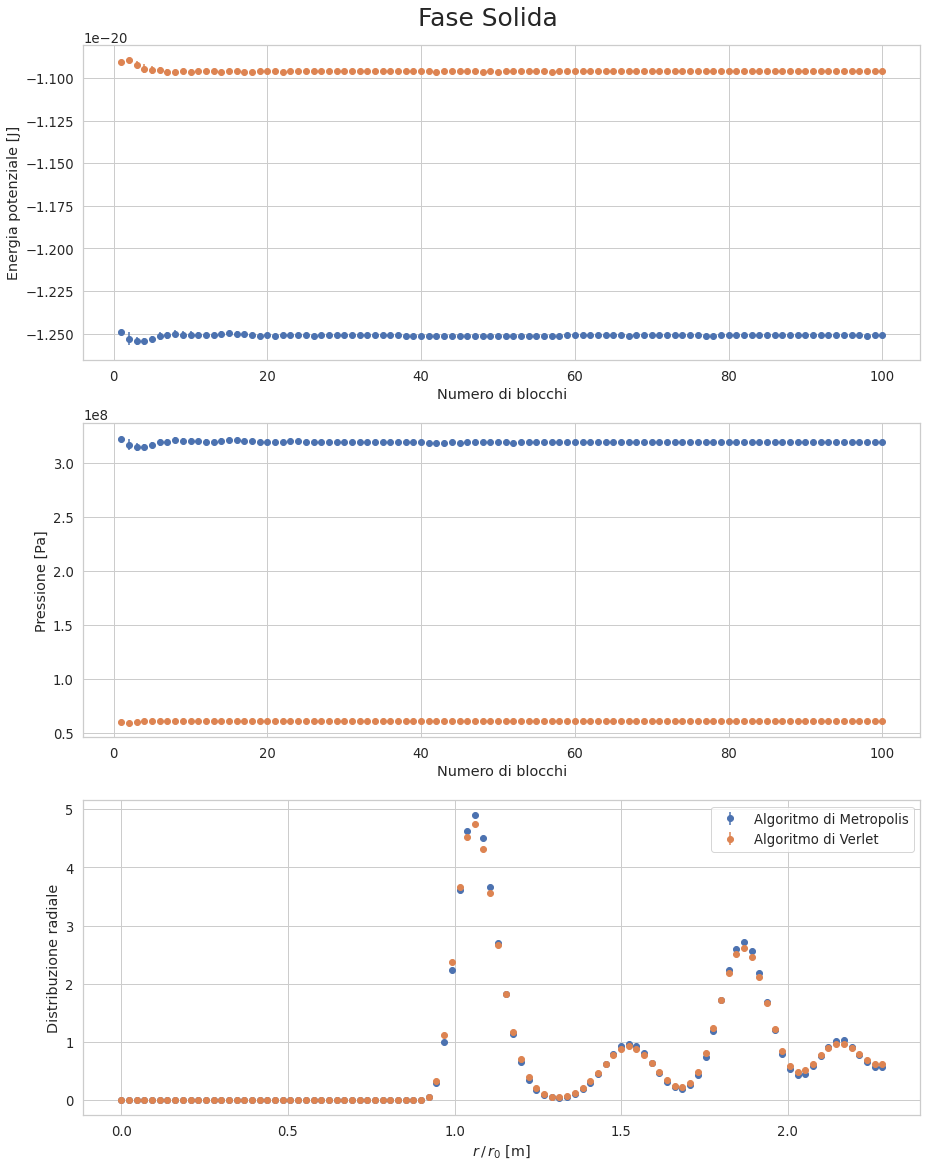

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(15,18)); 

fig.suptitle('Fase Solida',fontsize='xx-large')
fig.subplots_adjust(top=0.95)

ax[0].errorbar(
    np.arange(1,n_block+1,1),
    epot_NVT[0,:]*energy,
    yerr = epot_std_NVT[0,:]*energy, 
    marker='o', linestyle="", label='Algoritmo di Metropolis'
);


ax[0].errorbar(
    np.arange(1,n_block+1,1),
    epot[0,:]*energy,
    yerr = epot_std[0,:]*energy, 
    marker='o', linestyle="", label='Algortimo di Verlet'
);

ax[1].errorbar(
    np.arange(1,n_block+1,1),
    pres_NVT[0,:]*energy * length**(-3),
    yerr = pres_std_NVT[0,:]*energy * length**(-3), 
    marker='o', linestyle="", 
);

ax[1].errorbar(
    np.arange(1,n_block+1,1),
    pres[0,:]*energy * length**(-3),
    yerr = pres_std[0,:]*energy * length**(-3), 
    marker='o', linestyle="", label='Algoritmo di Metropolis'
);

ax[2].errorbar(
    r_NVT[0],
    gave_NVT[0,:],
    yerr = gave_std_NVT[0,:], 
    marker='o', linestyle="", label='Algoritmo di Metropolis'
);
    
ax[2].errorbar(
    r[0],
    gave[0,:],
    yerr = gave_std[0,:], 
    marker='o', linestyle="", label='Algoritmo di Verlet'
);


ax[0].set_xlabel('Numero di blocchi')
ax[0].set_ylabel('Energia potenziale [J]')

ax[1].set_xlabel('Numero di blocchi')
ax[1].set_ylabel('Pressione [Pa]')

ax[2].set_xlabel(r'$r\,/ \, r_0$ [m]')
ax[2].set_ylabel('Distribuzione radiale')

ax[2].legend();

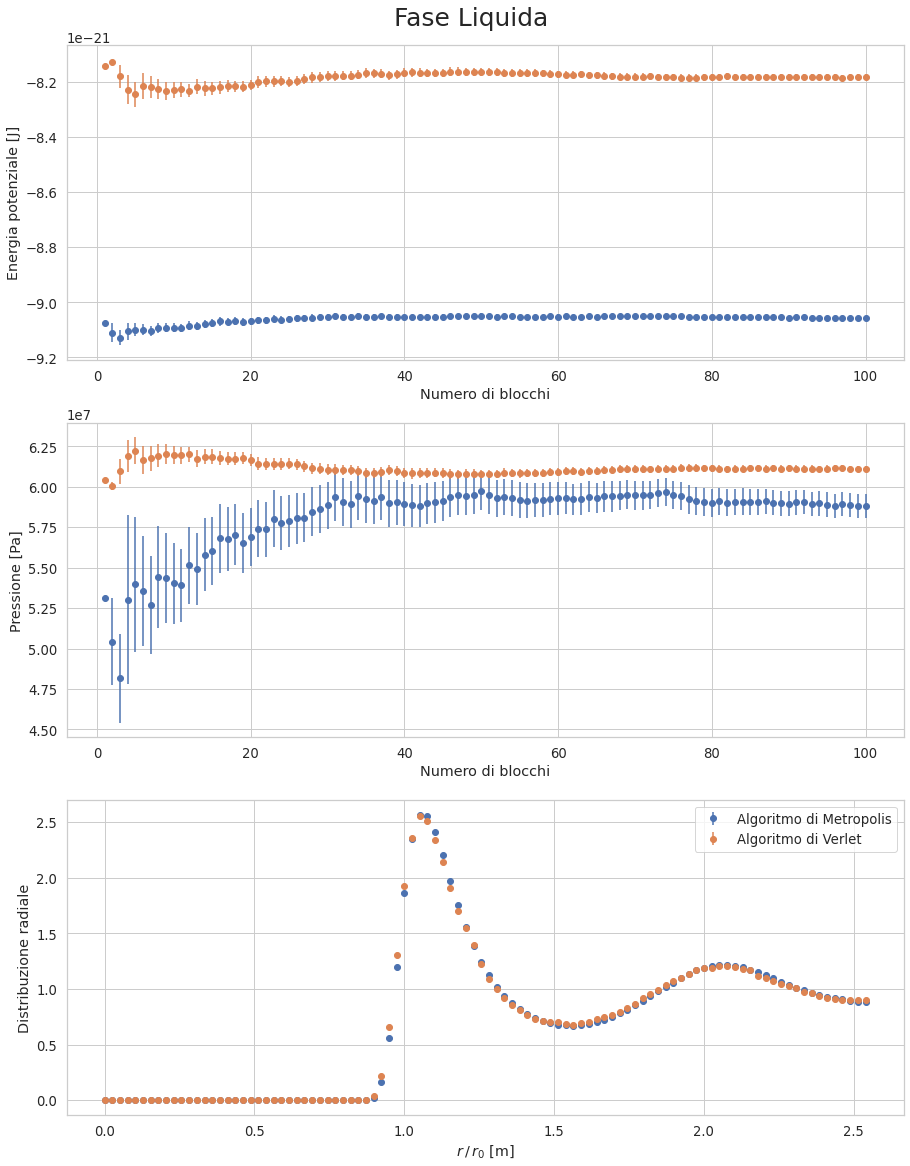

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(15,18)); 
fig.suptitle('Fase Liquida',fontsize='xx-large')
fig.subplots_adjust(top=0.95)

ax[0].errorbar(
    np.arange(1,n_block+1,1),
    epot_NVT[1,:]*energy,
    yerr = epot_std_NVT[1,:]*energy, 
    marker='o', linestyle="", 
);
    
ax[0].errorbar(
    np.arange(1,n_block+1,1),
    epot[1,:]*energy,
    yerr = epot_std[1,:]*energy, 
    marker='o', linestyle="", label='Algortimo di Verlet'
);

ax[1].errorbar(
    np.arange(1,n_block+1,1),
    pres_NVT[1,:]*energy * length**(-3),
    yerr = pres_std_NVT[1,:]*energy * length**(-3), 
    marker='o', linestyle="", label='Algoritmo di Metropolis'
);

ax[1].errorbar(
    np.arange(1,n_block+1,1),
    pres[1,:]*energy * length**(-3),
    yerr = pres_std[1,:]*energy * length**(-3), 
    marker='o', linestyle="", label='Algoritmo di Metropolis'
);

ax[2].errorbar(
    r_NVT[1],
    gave_NVT[1,:],
    yerr = gave_std_NVT[1,:], 
    marker='o', linestyle="", label='Algoritmo di Metropolis'
);
    
ax[2].errorbar(
    r[1],
    gave[1,:],
    yerr = gave_std[1,:], 
    marker='o', linestyle="", label='Algoritmo di Verlet'
);


ax[0].set_xlabel('Numero di blocchi')
ax[0].set_ylabel('Energia potenziale [J]')

ax[1].set_xlabel('Numero di blocchi')
ax[1].set_ylabel('Pressione [Pa]')

ax[2].set_xlabel(r'$r\,/ \, r_0$ [m]')
ax[2].set_ylabel('Distribuzione radiale')

ax[2].legend();

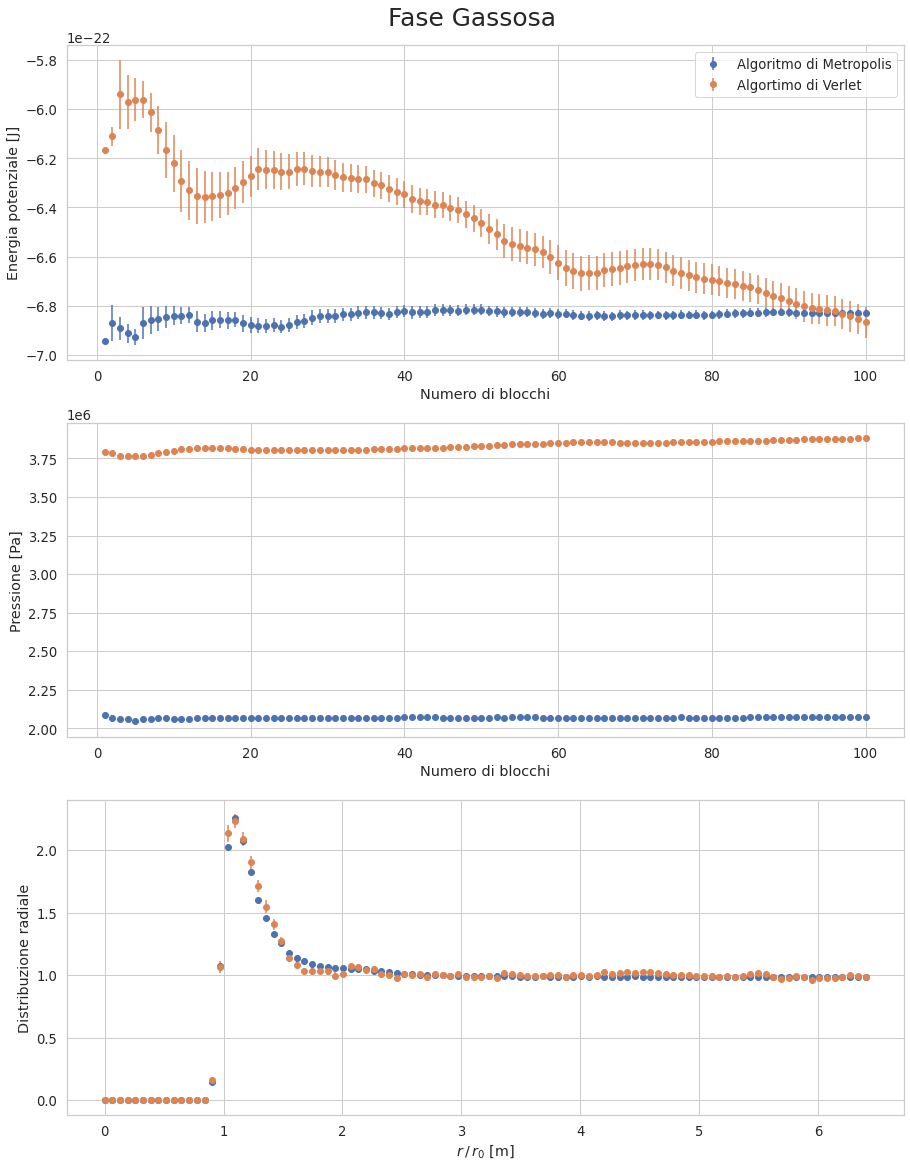

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(15,18)); 

fig.suptitle('Fase Gassosa',fontsize='xx-large')
fig.subplots_adjust(top=0.95)

ax[0].errorbar(
    np.arange(1,n_block+1,1),
    epot_NVT[2,:]*energy,
    yerr = epot_std_NVT[2,:]*energy, 
    marker='o', linestyle="", label='Algoritmo di Metropolis'
);
    
ax[0].errorbar(
    np.arange(1,n_block+1,1),
    epot[2,:]*energy,
    yerr = epot_std[2,:]*energy, 
    marker='o', linestyle="", label='Algortimo di Verlet'
);

ax[1].errorbar(
    np.arange(1,n_block+1,1),
    pres_NVT[2,:]*energy * length**(-3),
    yerr = pres_std_NVT[2,:]*energy * length**(-3), 
    marker='o', linestyle="", 
);

ax[1].errorbar(
    np.arange(1,n_block+1,1),
    pres[2,:]*energy * length**(-3),
    yerr = pres_std[2,:]*energy * length**(-3), 
    marker='o', linestyle="", label='Algoritmo di Metropolis'
);

ax[2].errorbar(
    r_NVT[2],
    gave_NVT[2,:],
    yerr = gave_std_NVT[1,:], 
    marker='o', linestyle="", label='Algoritmo di Metropolis'
);
    
ax[2].errorbar(
    r[2],
    gave[2,:],
    yerr = gave_std[2,:], 
    marker='o', linestyle="", label='Algoritmo di Verlet'
);


ax[0].set_xlabel('Numero di blocchi')
ax[0].set_ylabel('Energia potenziale [J]')

ax[1].set_xlabel('Numero di blocchi')
ax[1].set_ylabel('Pressione [Pa]')

ax[2].set_xlabel(r'$r\,/ \, r_0$ [m]')
ax[2].set_ylabel('Distribuzione radiale')

ax[0].legend();

> Quello che osserviamo è che, sebbbene per le singole misure di pressione ed energia potenziale, non otteniamo risultati compatibili, la funzioni di distribuzioni radiali sono praticamente le medesime. Questo ci dice che la configurazione spaziale che stiamo campionando è la stessa.